# Investment prediction

This notebook contains code that perform detailed exploratory data analysis and pre-processing, hypothesis testing, correlation analysis, model selection and evaluation, feature selection and model optimisation. This project is a binary classification problem which will provide insights and make predictions on which top 500 US companies have the highest average growth to invest in. 

### Insights & Recommendations

In conclusion, the selected model Random Forest performed the best with slight improvements after feature selection and hyperparameters tuning. It however requires further optimisation to lower the variance, it is recommended that an iterative process of feature selection and feature engineering with domain experts be done and to add more training data, test other algorithms and use other target variables.

While this model is not yet fit for production, the model evaluation process has however provided some valuable insights:

- Real Estate sector has the highest distribution Average Revenue Growth, followed by Health Care and Information Technology. The distribution of Average Revenue Growth of Real Estate sector showed it’s less of a risky investment, with no outliers and with highest average growth.
- The model predicted 85 companies to have Average Revenue Growth of over 0.7, predicting Charter Communications having the highest growth, followed by Facebook and Procter & Gamble.

This findings recommends to further research a select portfolio of potential acquisitions from 85 companies the model has predicted to have the highest growth (See end of notebook for the top 30 companies).


# 1. Data Wrangling

In [408]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pylab as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

from pprint import PrettyPrinter
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn import model_selection
from sklearn.model_selection import cross_val_score

In [409]:
pp = PrettyPrinter(indent=4)

In [410]:
# Read list of financial reports for each company for four years
fundamentals = pd.read_csv('data_files/fundamentals.csv', index_col=0)

In [411]:
# Extra information such as the company's name and GICS Sector
securities = pd.read_csv('data_files/securities.csv', index_col=0)

## Investigate Dataframes

A quick observation of the data informs us that we have 78 columns of data and each stock appears four times. Interestingly there is a variance in years reported where AAL reports between 2012-2015 whilst AAPL's first year of reports is 2013.

In [412]:
fundamentals.head()

,Ticker Symbol,Period Ending,Accounts Payable,Accounts Receivable,Add'l income/expense items,After Tax ROE,Capital Expenditures,Capital Surplus,Cash Ratio,Cash and Cash Equivalents,...,Total Current Assets,Total Current Liabilities,Total Equity,Total Liabilities,Total Liabilities & Equity,Total Revenue,Treasury Stock,For Year,Earnings Per Share,Estimated Shares Outstanding
0,AAL,2012-12-31,3.068000e+09,-222000000.0,-1.961000e+09,23.0,-1.888000e+09,4.695000e+09,53.0,1.330000e+09,...,7.072000e+09,9.011000e+09,-7.987000e+09,2.489100e+10,1.690400e+10,2.485500e+10,-367000000.0,2012.0,-5.60,3.350000e+08
1,AAL,2013-12-31,4.975000e+09,-93000000.0,-2.723000e+09,67.0,-3.114000e+09,1.059200e+10,75.0,2.175000e+09,...,1.432300e+10,1.380600e+10,-2.731000e+09,4.500900e+10,4.227800e+10,2.674300e+10,0.0,2013.0,-11.25,1.630222e+08
2,AAL,2014-12-31,4.668000e+09,-160000000.0,-1.500000e+08,143.0,-5.311000e+09,1.513500e+10,60.0,1.768000e+09,...,1.175000e+10,1.340400e+10,2.021000e+09,4.120400e+10,4.322500e+10,4.265000e+10,0.0,2014.0,4.02,7.169154e+08
3,AAL,2015-12-31,5.102000e+09,352000000.0,-7.080000e+08,135.0,-6.151000e+09,1.159100e+10,51.0,1.085000e+09,...,9.985000e+09,1.360500e+10,5.635000e+09,4.278000e+10,4.841500e+10,4.099000e+10,0.0,2015.0,11.39,6.681299e+08
4,AAP,2012-12-29,2.409453e+09,-89482000.0,6.000000e+05,32.0,-2.711820e+08,5.202150e+08,23.0,5.981110e+08,...,3.184200e+09,2.559638e+09,1.210694e+09,3.403120e+09,4.613814e+09,6.205003e+09,-27095000.0,2012.0,5.29,7.328355e+07


In [413]:
# Convert column from a string into a datetime object.

fundamentals['Period Ending'] = pd.to_datetime(fundamentals['Period Ending'])

In [414]:
fundamentals.head()

,Ticker Symbol,Period Ending,Accounts Payable,Accounts Receivable,Add'l income/expense items,After Tax ROE,Capital Expenditures,Capital Surplus,Cash Ratio,Cash and Cash Equivalents,...,Total Current Assets,Total Current Liabilities,Total Equity,Total Liabilities,Total Liabilities & Equity,Total Revenue,Treasury Stock,For Year,Earnings Per Share,Estimated Shares Outstanding
0,AAL,2012-12-31,3.068000e+09,-222000000.0,-1.961000e+09,23.0,-1.888000e+09,4.695000e+09,53.0,1.330000e+09,...,7.072000e+09,9.011000e+09,-7.987000e+09,2.489100e+10,1.690400e+10,2.485500e+10,-367000000.0,2012.0,-5.60,3.350000e+08
1,AAL,2013-12-31,4.975000e+09,-93000000.0,-2.723000e+09,67.0,-3.114000e+09,1.059200e+10,75.0,2.175000e+09,...,1.432300e+10,1.380600e+10,-2.731000e+09,4.500900e+10,4.227800e+10,2.674300e+10,0.0,2013.0,-11.25,1.630222e+08
2,AAL,2014-12-31,4.668000e+09,-160000000.0,-1.500000e+08,143.0,-5.311000e+09,1.513500e+10,60.0,1.768000e+09,...,1.175000e+10,1.340400e+10,2.021000e+09,4.120400e+10,4.322500e+10,4.265000e+10,0.0,2014.0,4.02,7.169154e+08
3,AAL,2015-12-31,5.102000e+09,352000000.0,-7.080000e+08,135.0,-6.151000e+09,1.159100e+10,51.0,1.085000e+09,...,9.985000e+09,1.360500e+10,5.635000e+09,4.278000e+10,4.841500e+10,4.099000e+10,0.0,2015.0,11.39,6.681299e+08
4,AAP,2012-12-29,2.409453e+09,-89482000.0,6.000000e+05,32.0,-2.711820e+08,5.202150e+08,23.0,5.981110e+08,...,3.184200e+09,2.559638e+09,1.210694e+09,3.403120e+09,4.613814e+09,6.205003e+09,-27095000.0,2012.0,5.29,7.328355e+07


Securities provides information such as the name of the company and the primary industry.

In [415]:
securities.head()

,Security,SEC filings,GICS Sector,GICS Sub Industry,Address of Headquarters,Date first added,CIK
Ticker Symbol,,,,,,,
MMM,3M Company,reports,Industrials,Industrial Conglomerates,"St. Paul, Minnesota",NaN,66740
ABT,Abbott Laboratories,reports,Health Care,Health Care Equipment,"North Chicago, Illinois",31/3/64,1800
ABBV,AbbVie,reports,Health Care,Pharmaceuticals,"North Chicago, Illinois",31/12/12,1551152
ACN,Accenture plc,reports,Information Technology,IT Consulting & Other Services,"Dublin, Ireland",6/7/11,1467373
ATVI,Activision Blizzard,reports,Information Technology,Home Entertainment Software,"Santa Monica, California",31/8/15,718877


Check the possible values for types of companies, we see that there are only 11 total industries.

In [416]:
pd.Series(np.unique(securities['GICS Sector'].values))

0          Consumer Discretionary
1                Consumer Staples
2                          Energy
3                      Financials
4                     Health Care
5                     Industrials
6          Information Technology
7                       Materials
8                     Real Estate
9     Telecommunications Services
10                      Utilities
dtype: object

In [417]:
securities[['Security', 'GICS Sector']]

,Security,GICS Sector
Ticker Symbol,,
MMM,3M Company,Industrials
ABT,Abbott Laboratories,Health Care
ABBV,AbbVie,Health Care
ACN,Accenture plc,Information Technology
ATVI,Activision Blizzard,Information Technology
...,...,...
YHOO,Yahoo Inc.,Information Technology
YUM,Yum! Brands Inc,Consumer Discretionary
ZBH,Zimmer Biomet Holdings,Health Care


## Calculate average revenue growth

The provided data provides the revenue for selected years however we're interested in predicting revenue growth. The following function calculate the average revenue growth per year for each stock. To do so we calculate the increase of revenue divided by the company's original revenue then divide it by the number of years separating the entries.

In [418]:
def calculateRevGrowth(df):
    lastIndex = df.index[-1]
    firstIndex = df.index[0]
    firstYear = df['Period Ending'][firstIndex].year
    lastYear = df['Period Ending'][lastIndex].year
    numYears = lastYear - firstYear + 1
    avgGrowth = ((df['Total Revenue'][lastIndex] - df['Total Revenue'][firstIndex])/(df['Total Revenue'][firstIndex]*numYears))*100
    return avgGrowth
    


In [419]:
growthList = []
for ticker in np.unique(fundamentals['Ticker Symbol'].values):
    avgGrowth = calculateRevGrowth(fundamentals.loc[fundamentals['Ticker Symbol']==ticker])
    growthList.append([ticker, avgGrowth])

# Convert company growth into a pandas dataframe.
growthFrame = pd.DataFrame(growthList, columns = ['Ticker Symbol', 'Avg Rev Growth'])
growthFrame= growthFrame.set_index('Ticker Symbol')
growthFrame

,Avg Rev Growth
Ticker Symbol,
AAL,16.229129
AAP,11.384410
AAPL,6.542771
ABBV,6.092220
ABC,16.738028
...,...
YHOO,-0.091571
YUM,-0.968239
ZBH,8.531990


## Calculate mean values of fundamentals data points over last four years

Having calculated the averaged revenue growth for each company we'll now average all other data points for each company across entries. This allows us to create a dataset where we can see the average revenue growth across the stated years as well as the average expendeiture/ income /etc of other variables for the same time period.

In [420]:
companyAveraged = fundamentals.groupby(['Ticker Symbol']).mean()
companyAveraged

,Accounts Payable,Accounts Receivable,Add'l income/expense items,After Tax ROE,Capital Expenditures,Capital Surplus,Cash Ratio,Cash and Cash Equivalents,Changes in Inventories,Common Stocks,...,Total Current Assets,Total Current Liabilities,Total Equity,Total Liabilities,Total Liabilities & Equity,Total Revenue,Treasury Stock,For Year,Earnings Per Share,Estimated Shares Outstanding
Ticker Symbol,,,,,,,,,,,,,,,,,,,,,
AAL,4.453250e+09,-3.075000e+07,-1.385500e+09,92.00,-4.116000e+09,1.050325e+10,59.75,1.589500e+09,0.000000e+00,3.625000e+07,...,1.078250e+10,1.245650e+10,-7.655000e+08,3.847100e+10,3.770550e+10,3.380950e+10,-9.175000e+07,2013.5,-0.3600,4.707669e+08
AAP,3.097954e+09,-4.789875e+07,-2.735000e+05,25.50,-2.325330e+08,5.544462e+08,17.00,4.765088e+08,-2.338910e+08,7.000000e+03,...,4.213842e+09,3.194079e+09,1.797615e+09,4.771263e+09,6.568878e+09,8.069924e+09,-9.193450e+07,2013.5,5.9625,7.323176e+07
AAPL,5.121600e+10,-2.620250e+09,1.192250e+09,36.50,-1.042925e+10,0.000000e+00,67.50,1.742675e+10,-2.675000e+08,2.543600e+10,...,8.451600e+10,6.668050e+10,1.206750e+11,1.420425e+11,2.627175e+11,2.007648e+11,0.000000e+00,2014.5,16.0375,4.559555e+09
ABBV,6.899750e+09,-8.600000e+07,-2.297500e+08,457.75,-4.920000e+08,5.236250e+09,103.25,8.060750e+09,-2.240000e+08,1.225000e+07,...,1.639925e+10,8.985500e+09,2.457250e+09,3.173500e+10,3.419225e+10,1.999725e+10,-2.532750e+09,2014.0,2.2800,1.610405e+09
ABC,1.959230e+10,-1.410580e+09,-1.695250e+07,30.50,-2.907770e+08,3.294914e+09,9.75,1.987198e+09,-1.319396e+09,2.729250e+06,...,1.859505e+10,1.974508e+10,1.755608e+09,2.376189e+10,2.551750e+10,1.225849e+11,-3.094310e+09,2014.5,2.3025,2.226236e+08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
YHOO,1.840122e+09,1.279100e+07,3.793449e+09,17.75,-4.539150e+08,8.889600e+09,303.50,2.260344e+09,0.000000e+00,1.026500e+06,...,6.907578e+09,2.105727e+09,2.385512e+10,1.134976e+10,3.520488e+10,4.813345e+09,-7.980648e+08,2013.5,1.8950,1.042708e+09
YUM,2.192500e+09,-2.625000e+07,0.000000e+00,83.50,-1.038500e+09,0.000000e+00,31.25,7.735000e+08,1.575000e+07,0.000000e+00,...,1.714250e+09,2.510250e+09,1.694500e+09,6.834750e+09,8.529250e+09,1.327525e+10,0.000000e+00,2013.5,2.8025,4.482678e+08
ZBH,3.079750e+08,-5.407500e+07,-9.275000e+06,9.25,-3.332250e+08,5.006800e+09,155.25,1.126875e+09,-1.464000e+08,2.725000e+06,...,4.520650e+09,1.134875e+09,7.149000e+09,6.718625e+09,1.386762e+10,4.941550e+09,-5.842650e+09,2013.5,3.4625,1.765308e+08


## Merge CSVs to identify company

Combine company information to the fundamentals data frame

In [421]:
securities = pd.merge(securities, growthFrame, left_index=True, right_index=True)

In [422]:
combined = pd.merge(companyAveraged, securities[['Security', 'GICS Sector', 'Avg Rev Growth']], left_index=True, right_index=True)

In [423]:
combined.head()

,Accounts Payable,Accounts Receivable,Add'l income/expense items,After Tax ROE,Capital Expenditures,Capital Surplus,Cash Ratio,Cash and Cash Equivalents,Changes in Inventories,Common Stocks,...,Total Liabilities,Total Liabilities & Equity,Total Revenue,Treasury Stock,For Year,Earnings Per Share,Estimated Shares Outstanding,Security,GICS Sector,Avg Rev Growth
Ticker Symbol,,,,,,,,,,,,,,,,,,,,,
AAL,4.453250e+09,-3.075000e+07,-1.385500e+09,92.00,-4.116000e+09,1.050325e+10,59.75,1.589500e+09,0.000000e+00,3.625000e+07,...,3.847100e+10,3.770550e+10,3.380950e+10,-9.175000e+07,2013.5,-0.3600,4.707669e+08,American Airlines Group,Industrials,16.229129
AAP,3.097954e+09,-4.789875e+07,-2.735000e+05,25.50,-2.325330e+08,5.544462e+08,17.00,4.765088e+08,-2.338910e+08,7.000000e+03,...,4.771263e+09,6.568878e+09,8.069924e+09,-9.193450e+07,2013.5,5.9625,7.323176e+07,Advance Auto Parts,Consumer Discretionary,11.384410
AAPL,5.121600e+10,-2.620250e+09,1.192250e+09,36.50,-1.042925e+10,0.000000e+00,67.50,1.742675e+10,-2.675000e+08,2.543600e+10,...,1.420425e+11,2.627175e+11,2.007648e+11,0.000000e+00,2014.5,16.0375,4.559555e+09,Apple Inc.,Information Technology,6.542771
ABBV,6.899750e+09,-8.600000e+07,-2.297500e+08,457.75,-4.920000e+08,5.236250e+09,103.25,8.060750e+09,-2.240000e+08,1.225000e+07,...,3.173500e+10,3.419225e+10,1.999725e+10,-2.532750e+09,2014.0,2.2800,1.610405e+09,AbbVie,Health Care,6.092220
ABC,1.959230e+10,-1.410580e+09,-1.695250e+07,30.50,-2.907770e+08,3.294914e+09,9.75,1.987198e+09,-1.319396e+09,2.729250e+06,...,2.376189e+10,2.551750e+10,1.225849e+11,-3.094310e+09,2014.5,2.3025,2.226236e+08,AmerisourceBergen Corp,Health Care,16.738028


In [424]:
# Export combined dataset
combined.to_csv('combined_data.csv')

# 2. Exploratory data analysis and pre-processing
Initial data preparation and pre-processing of the Russell 3000 Index financial data were done, through first loading and merging various datasets and with total of 78 variables initially identified. The target variable Average Annual Revenue Growth was created by calculating the increase of revenue divided by the company's original revenue then divided it by the number of years separating the entries. Data were also cleaned, where missing data were filled and outliers removed.

## Explore combined dataset

In [425]:
# Inspect the shape
combined.shape

(448, 79)

There are 448 rows and 79 columns, including the target variable 'Avg Rev Growth'

In [426]:
# Check the datatypes
combined.dtypes

Accounts Payable                float64
Accounts Receivable             float64
Add'l income/expense items      float64
After Tax ROE                   float64
Capital Expenditures            float64
                                 ...   
Earnings Per Share              float64
Estimated Shares Outstanding    float64
Security                         object
GICS Sector                      object
Avg Rev Growth                  float64
Length: 79, dtype: object

In [427]:
# Check object types and null counts
combined.info()

<class 'pandas.core.frame.DataFrame'>
Index: 448 entries, AAL to ZTS
Data columns (total 79 columns):
 #   Column                                               Non-Null Count  Dtype  
---  ------                                               --------------  -----  
 0   Accounts Payable                                     448 non-null    float64
 1   Accounts Receivable                                  448 non-null    float64
 2   Add'l income/expense items                           448 non-null    float64
 3   After Tax ROE                                        448 non-null    float64
 4   Capital Expenditures                                 448 non-null    float64
 5   Capital Surplus                                      448 non-null    float64
 6   Cash Ratio                                           373 non-null    float64
 7   Cash and Cash Equivalents                            448 non-null    float64
 8   Changes in Inventories                               448 non-null    floa

Dataframe info shows that there are some nulls and columns 'Security' and 'GICS Sector' are categorical columns. 'For Year' column should be a categorical column too.

In [428]:
# Fill nulls with zeros
combined = combined.fillna(0)

In [429]:
# Convert columns 'Security','GICS Sector' and 'For Year' as categorical columns. 

combined['Security'] = combined['Security'].astype('category')
combined['GICS Sector'] = combined['GICS Sector'].astype('category')

## Analyse summary statistics for target variable Avg Rev Growth

The summary statistics show the target variable 'Avg Rev Growth' has standard variation and a high tail (3rd quartile is 7.18 whilst the maximum value is 1243). This indicates there are some outliers present in the dataset.

In [430]:
# Check the summary statistics for target variable 'Avg Rev Growth'
combined['Avg Rev Growth'].describe()

count     448.000000
mean        7.332211
std        59.373189
min       -15.286401
25%        -0.577717
50%         2.664451
75%         7.188243
max      1243.690552
Name: Avg Rev Growth, dtype: float64

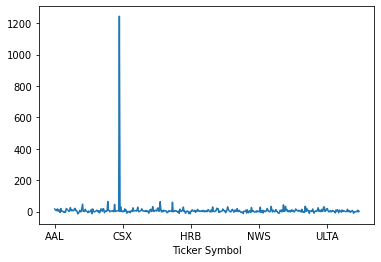

In [431]:
# Plot the distribution of target variable 'Avg Rev Growth'
ax = combined['Avg Rev Growth'].plot()

By sorting the column 'Avg Rev Growth', the outlier with Ticker Symbol = 'COTY' is identified:

In [432]:
combined['Avg Rev Growth'].sort_values()

Ticker Symbol
APA      -15.286401
HPQ      -14.261162
BHI      -13.999061
MRO      -13.463146
HP       -13.013451
           ...     
AVGO      47.010551
GILD      59.103793
FB        62.773120
CHTR      63.911711
COTY    1243.690552
Name: Avg Rev Growth, Length: 448, dtype: float64

In [433]:
# Remove outlier COTY
reduced = combined.drop(['COTY'])

By removing outlier, the standard deviation for target variable 'Avg Rev Growth' is has now reduced from 59 to 9 and plotting the distribution presents a positively skewed distribution

In [434]:
# Check the summary statistics for target variable 'Avg Rev Growth'
reduced['Avg Rev Growth'].describe()

count    447.000000
mean       4.566309
std        9.904465
min      -15.286401
25%       -0.590839
50%        2.656497
75%        7.178388
max       63.911711
Name: Avg Rev Growth, dtype: float64

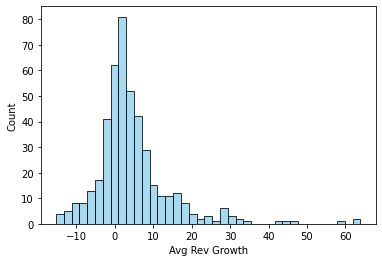

In [604]:
# Plot the distribution of target variable 'Avg Rev Growth'
ax =sns.histplot(reduced["Avg Rev Growth"], color="skyblue", label="Avg Rev Growth", kde=False)

By analysing and plotting the distribution of Avg Rev Growth' by GICS Sector it shows that Real Estate has higher distribution Average revenue growth, followed by Health Care and Information Technology.

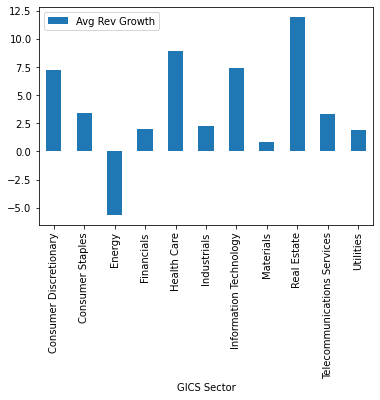

In [605]:
# Plot the Avg Rev Growth by sector
industryGrouped = reduced.groupby(by=["GICS Sector"]).mean()
industryGrouped
ax = industryGrouped.plot.bar(y='Avg Rev Growth')

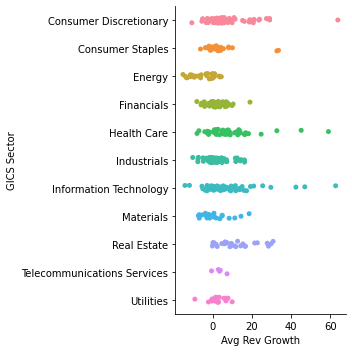

In [437]:
# Plot the distribution target variable 'Avg Rev Growth' by GICS Sector
sns.catplot(x="Avg Rev Growth", y="GICS Sector", data=reduced)

## Analyse the correlation between variables

In [438]:
# Plot correlation matrix
corr = reduced.corr()
mask = np.zeros_like(corr, dtype=bool)
mask[np.triu_indices_from(mask)] = True
corr[mask] = np.nan
(corr
 .style
 .background_gradient(cmap='coolwarm', axis=None)
 .highlight_null(null_color='#f1f1f1')  # Color NaNs grey
)

,Accounts Payable,Accounts Receivable,Add'l income/expense items,After Tax ROE,Capital Expenditures,Capital Surplus,Cash Ratio,Cash and Cash Equivalents,Changes in Inventories,Common Stocks,Cost of Revenue,Current Ratio,Deferred Asset Charges,Deferred Liability Charges,Depreciation,Earnings Before Interest and Tax,Earnings Before Tax,Effect of Exchange Rate,Equity Earnings/Loss Unconsolidated Subsidiary,Fixed Assets,Goodwill,Gross Margin,Gross Profit,Income Tax,Intangible Assets,Interest Expense,Inventory,Investments,Liabilities,Long-Term Debt,Long-Term Investments,Minority Interest,Misc. Stocks,Net Borrowings,Net Cash Flow,Net Cash Flow-Operating,Net Cash Flows-Financing,Net Cash Flows-Investing,Net Income,Net Income Adjustments,Net Income Applicable to Common Shareholders,Net Income-Cont. Operations,Net Receivables,Non-Recurring Items,Operating Income,Operating Margin,Other Assets,Other Current Assets,Other Current Liabilities,Other Equity,Other Financing Activities,Other Investing Activities,Other Liabilities,Other Operating Activities,Other Operating Items,Pre-Tax Margin,Pre-Tax ROE,Profit Margin,Quick Ratio,Research and Development,Retained Earnings,Sale and Purchase of Stock,"Sales, General and Admin.",Short-Term Debt / Current Portion of Long-Term Debt,Short-Term Investments,Total Assets,Total Current Assets,Total Current Liabilities,Total Equity,Total Liabilities,Total Liabilities & Equity,Total Revenue,Treasury Stock,For Year,Earnings Per Share,Estimated Shares Outstanding,Avg Rev Growth
Accounts Payable,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
Accounts Receivable,0.192003,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
Add'l income/expense items,0.202057,0.006628,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
After Tax ROE,-0.026405,0.009436,-0.033506,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
Capital Expenditures,-0.270402,0.065641,-0.552047,0.020660,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
Capital Surplus,0.454944,0.219083,0.016144,-0.050385,-0.219673,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
Cash Ratio,-0.107209,-0.063068,0.057426,0.044060,0.062490,-0.039289,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
Cash and Cash Equivalents,0.810150,0.244570,0.044178,-0.032100,0.005939,0.492394,-

In [439]:
# Calculate the correlation matrix and reshape
df_corr = reduced.corr().stack().reset_index()

# rename the columns
df_corr.columns = ['FEATURE_1', 'FEATURE_2', 'CORRELATION']

# create a mask to identify rows with duplicate features as mentioned above
mask_dups = (df_corr[['FEATURE_1', 'FEATURE_2']].apply(frozenset, axis=1).duplicated()) | (df_corr['FEATURE_1']==df_corr['FEATURE_2']) 

# apply the mask to clean the correlation dataframe
df_corr = df_corr[~mask_dups]

In [440]:
# Show highly positive correlated features pairs with Pearson’s correlation coefficient >= 0.85
positive_corr = df_corr.loc[df_corr['CORRELATION'] >= 0.90]
positive_corr

,FEATURE_1,FEATURE_2,CORRELATION
287,After Tax ROE,Pre-Tax ROE,0.994503
520,Cash Ratio,Quick Ratio,0.927476
569,Cash and Cash Equivalents,Long-Term Investments,0.947221
587,Cash and Cash Equivalents,Other Current Liabilities,0.989964
604,Cash and Cash Equivalents,Total Assets,0.922065
608,Cash and Cash Equivalents,Total Liabilities,0.925654
609,Cash and Cash Equivalents,Total Liabilities & Equity,0.922067
841,Cost of Revenue,Total Revenue,0.957399
905,Current Ratio,Quick Ratio,0.943008
1171,Earnings Before Interest and Tax,Earnings Before Tax,0.984904


In [441]:
# Show highly negative correlated features pairs with Pearson’s correlation coefficient <= -0.85
negative_corr = df_corr.loc[df_corr['CORRELATION'] <= -0.90]
negative_corr

,FEATURE_1,FEATURE_2,CORRELATION
327,Capital Expenditures,Fixed Assets,-0.928605


In [442]:
# Combine highly correlated features in a dataframe
correlated_features = positive_corr.append(negative_corr, sort=False)
correlated_features

,FEATURE_1,FEATURE_2,CORRELATION
287,After Tax ROE,Pre-Tax ROE,0.994503
520,Cash Ratio,Quick Ratio,0.927476
569,Cash and Cash Equivalents,Long-Term Investments,0.947221
587,Cash and Cash Equivalents,Other Current Liabilities,0.989964
604,Cash and Cash Equivalents,Total Assets,0.922065
608,Cash and Cash Equivalents,Total Liabilities,0.925654
609,Cash and Cash Equivalents,Total Liabilities & Equity,0.922067
841,Cost of Revenue,Total Revenue,0.957399
905,Current Ratio,Quick Ratio,0.943008
1171,Earnings Before Interest and Tax,Earnings Before Tax,0.984904


Based on the analysis above, shows pairs of highly correlated features where the Pearson’s correlation coefficient is either greater or equal to 0.85 or less than or equal to -0.85. For this reason, a new version of the dataset will be used where only one of the paired features will be included in the model. This is to see if removing correlated features improve the model performance.

### Test hypothesis from EDA

The correlation analysis have shown that there are many highly correlated features. One of the correlation that will be tested here is the correlation between __Long-Term Investments__ and __Total Liabilities & Equity__.<br>
<br>
__Null hypothesis:__ There __IS__ a correlation between __Long-Term Investments__ and __Total Liabilities & Equity__<br>
__Alternate hypothesis:__ There is __NO__ correlation between __Long-Term Investments__ and __Total Liabilities & Equity__<br>

In [443]:
# Define Long-Term Investments and Total Liabilities & Equity variables
x = reduced["Long-Term Investments"]
y= reduced["Total Liabilities & Equity"]

In [444]:
import scipy.stats as stats
# Calculate the pearson correlation coefficient between alcohol use and marijuana frequency
r = stats.pearsonr(x, y)[0]
print(r)

0.9811053937236845


In [445]:
# Boothstrap function with 1000 interations
def bootstrap_r(x, y, iterations=1000):
    boot_r = []
    inds = list(range(len(x)))
    for i in range(iterations):
        boot_inds = np.random.choice(inds, replace=True, size=len(inds))
        x_b = x[boot_inds]
        y_b = y[boot_inds]
        boot_r.append(stats.pearsonr(x_b, y_b)[0])
    return boot_r

In [446]:
# Calculate the 95% confidence interval of the correlation using bootstrap function
r_boots = bootstrap_r(x, y)

# 95%
lower = stats.scoreatpercentile(r_boots, 2.5)
upper = stats.scoreatpercentile(r_boots, 97.5)

print(lower, r, upper)

0.9214944057122135 0.9811053937236845 0.9912611080186056


As per the results of running the variables using the bootstrap function, the 95% confidence interval that our correlation is between 0.92 and 0.99 and we can therefore accept the null hypothesis, that there is a positive linear correlation between these two variables as shown in the distribution plot below.

<AxesSubplot:ylabel='Count'>

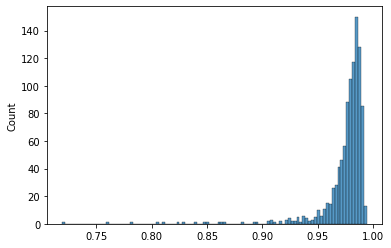

In [615]:
sns.histplot(r_boots)

# 2. Data Modelling

The models that will be created will be classification models and for this reason the target variable needs to be coverted to a binary. The threshold assumed in this model is equal to 0.7 of Avg Rev Growth, meaning that any company with annual growth above to 0.7 will be classified as revGrowthAboveSeven = 1. The classifiers that will be evaluated and compared are Random Forest, Gradient boosting, Support Vector Machine (SVM), Logistic Regression and Naive Bayes.

In [447]:
# Convert Avg Rev Growth to binary target variable 
threshold = 0.7
reduced['revGrowthAboveSeven'] = reduced['Avg Rev Growth'].apply(lambda x: 1 if x>threshold else 0)

In [448]:
reduced.head()

,Accounts Payable,Accounts Receivable,Add'l income/expense items,After Tax ROE,Capital Expenditures,Capital Surplus,Cash Ratio,Cash and Cash Equivalents,Changes in Inventories,Common Stocks,...,Total Liabilities & Equity,Total Revenue,Treasury Stock,For Year,Earnings Per Share,Estimated Shares Outstanding,Security,GICS Sector,Avg Rev Growth,revGrowthAboveSeven
Ticker Symbol,,,,,,,,,,,,,,,,,,,,,
AAL,4.453250e+09,-3.075000e+07,-1.385500e+09,92.00,-4.116000e+09,1.050325e+10,59.75,1.589500e+09,0.000000e+00,3.625000e+07,...,3.770550e+10,3.380950e+10,-9.175000e+07,2013.5,-0.3600,4.707669e+08,American Airlines Group,Industrials,16.229129,1
AAP,3.097954e+09,-4.789875e+07,-2.735000e+05,25.50,-2.325330e+08,5.544462e+08,17.00,4.765088e+08,-2.338910e+08,7.000000e+03,...,6.568878e+09,8.069924e+09,-9.193450e+07,2013.5,5.9625,7.323176e+07,Advance Auto Parts,Consumer Discretionary,11.384410,1
AAPL,5.121600e+10,-2.620250e+09,1.192250e+09,36.50,-1.042925e+10,0.000000e+00,67.50,1.742675e+10,-2.675000e+08,2.543600e+10,...,2.627175e+11,2.007648e+11,0.000000e+00,2014.5,16.0375,4.559555e+09,Apple Inc.,Information Technology,6.542771,1
ABBV,6.899750e+09,-8.600000e+07,-2.297500e+08,457.75,-4.920000e+08,5.236250e+09,103.25,8.060750e+09,-2.240000e+08,1.225000e+07,...,3.419225e+10,1.999725e+10,-2.532750e+09,2014.0,2.2800,1.610405e+09,AbbVie,Health Care,6.092220,1
ABC,1.959230e+10,-1.410580e+09,-1.695250e+07,30.50,-2.907770e+08,3.294914e+09,9.75,1.987198e+09,-1.319396e+09,2.729250e+06,...,2.551750e+10,1.225849e+11,-3.094310e+09,2014.5,2.3025,2.226236e+08,AmerisourceBergen Corp,Health Care,16.738028,1


In [449]:
# Check if dataset is imbalanced
class_count = reduced['revGrowthAboveSeven']
class_count.value_counts()

value_counts = class_count.value_counts()
baseline = class_count.value_counts() / class_count.count()

print(class_count.value_counts())
print(baseline)

1    298
0    149
Name: revGrowthAboveSeven, dtype: int64
1    0.666667
0    0.333333
Name: revGrowthAboveSeven, dtype: float64


The analysis of the classes show that dataset is mildy imbalanced (67% / 33 %) and for this reason Precision-Recall will be used to evaluate model performance. Precision-Recall curves summarize the trade-off between the true positive rate and the positive predictive value for a predictive model using different probability thresholds.

In [450]:
# Convert categorical variable 'GICS Sector' as number and name it as 'Industry' so it can be included in the model.
features = reduced
features['Industry'] = pd.factorize(reduced['GICS Sector'])[0]

In [451]:
# Prepare dataset for modelling by removing target variables Avg Rev Growth, GICS Sector, Security
target = reduced['revGrowthAboveSeven']
features = reduced.drop(columns=['Avg Rev Growth', 'revGrowthAboveSeven', 'Security','GICS Sector'])

Some algorithms are sensitive to scaling, for this reason the dataset will be standardised

In [452]:
# Standardise dataset
ss = StandardScaler()
Xn = ss.fit_transform(features)

In [453]:
# Split dataset to train (70%) and test (30%)
X_train, X_test, y_train, y_test = train_test_split(
    Xn, target, test_size=0.3, random_state=0
)

## Model development and validation

Since there is a higher cost for False positive, or incorrect predictions to invest companies that are actually making losses, the metric that are useful when comparing these models is the Precision metric, as opposed to a False negative means that the company is missing out on investing on growth investments but not necessarily losing money.

### Random Forest

In [454]:
# Initialise Initialise random forest classifier and train model
randomForestClassifier = RandomForestClassifier(n_estimators=200, n_jobs=-1, random_state=0)
randomForestClassifier.fit(X_train, y_train)
randomForestClassifier.score(X_train, y_train)

1.0

In [455]:
# Calculate accuracy of model using testing data
randomForestClassifier.score(X_test, y_test)

0.7333333333333333

In [456]:
# Mean accuracy after cross validation (5 splits)
scores = cross_val_score(randomForestClassifier, Xn, target, cv=5)
print('Fold scores:\t\t\t', scores)
print('Cross-validation accuracy:\t', round(scores.mean(), 2))

Fold scores:			 [0.73333333 0.7        0.86516854 0.80898876 0.70786517]
Cross-validation accuracy:	 0.76


In [457]:
# Print metrics precision, recall and f1-score
print(classification_report(y_test, randomForestClassifier.predict(X_test)))

              precision    recall  f1-score   support

           0       0.75      0.42      0.54        50
           1       0.73      0.92      0.81        85

    accuracy                           0.73       135
   macro avg       0.74      0.67      0.68       135
weighted avg       0.74      0.73      0.71       135



### Gradient boosting

In [458]:
# Initialise Initialise Gradient boosting classifier and train model
gradientBoostingClassifier = GradientBoostingClassifier(n_estimators=200, random_state=0)
gradientBoostingClassifier.fit(X_train, y_train)
gradientBoostingClassifier.score(X_train, y_train)

1.0

In [459]:
# Calculate accuracy of model using testing data
gradientBoostingClassifier.score(X_test, y_test)

0.7185185185185186

In [460]:
# Mean accuracy after cross validation (5 splits)
scores = cross_val_score(gradientBoostingClassifier, Xn, target, cv=5)
print('Fold scores:\t\t\t', scores)
print('Cross-validation accuracy:\t', round(scores.mean(), 2))

Fold scores:			 [0.71111111 0.72222222 0.82022472 0.79775281 0.71910112]
Cross-validation accuracy:	 0.75


In [461]:
# Print metrics precision, recall and f1-score
print(classification_report(y_test, gradientBoostingClassifier.predict(X_test)))

              precision    recall  f1-score   support

           0       0.69      0.44      0.54        50
           1       0.73      0.88      0.80        85

    accuracy                           0.72       135
   macro avg       0.71      0.66      0.67       135
weighted avg       0.71      0.72      0.70       135



### Support vector machine (SVM)

In [462]:
# Initialise Initialise SVM classifier and train model
SVMClassifier = SVC(kernel='linear')
SVMClassifier.fit(X_train,y_train)
SVMClassifier.score(X_train, y_train)

0.8493589743589743

In [463]:
# Calculate accuracy of model using testing data
SVMClassifier.score(X_test, y_test)

0.7333333333333333

In [464]:
# Mean accuracy after cross validation (5 splits)
scores = cross_val_score(SVMClassifier, Xn, target, cv=5)
print('Fold scores:\t\t\t', scores)
print('Cross-validation accuracy:\t', round(scores.mean(), 2))

Fold scores:			 [0.76666667 0.7        0.80898876 0.76404494 0.70786517]
Cross-validation accuracy:	 0.75


In [465]:
# Print metrics precision, recall and f1-score
print(classification_report(y_test, SVMClassifier.predict(X_test)))

              precision    recall  f1-score   support

           0       0.75      0.42      0.54        50
           1       0.73      0.92      0.81        85

    accuracy                           0.73       135
   macro avg       0.74      0.67      0.68       135
weighted avg       0.74      0.73      0.71       135



### Logistic regression

In [466]:
# Initialise Initialise Logistic regression classifier and train model
logRegClassifier = LogisticRegression()
logRegClassifier.fit(X_train,y_train)
logRegClassifier.score(X_train, y_train)

0.842948717948718

In [467]:
# Calculate accuracy of model using testing data
logRegClassifier.score(X_test, y_test)

0.7037037037037037

In [468]:
# Mean accuracy after cross validation (5 splits)
scores = cross_val_score(logRegClassifier, Xn, target, cv=5)
print('Fold scores:\t\t\t', scores)
print('Cross-validation accuracy:\t', round(scores.mean(), 2))

Fold scores:			 [0.77777778 0.7        0.80898876 0.76404494 0.71910112]
Cross-validation accuracy:	 0.75


In [469]:
# Print metrics precision, recall and f1-score
print(classification_report(y_test, logRegClassifier.predict(X_test)))

              precision    recall  f1-score   support

           0       0.71      0.34      0.46        50
           1       0.70      0.92      0.80        85

    accuracy                           0.70       135
   macro avg       0.71      0.63      0.63       135
weighted avg       0.70      0.70      0.67       135



### Naive Bayes

In [470]:
# Initialise Initialise Naive Bayes classifier and train model
NBClassifier = GaussianNB()
NBClassifier.fit(X_train,y_train)
NBClassifier.score(X_train, y_train)

0.7083333333333334

In [471]:
# Calculate accuracy of model using testing data
NBClassifier.score(X_test, y_test)

0.6370370370370371

In [472]:
# Mean accuracy after cross validation (5 splits)
scores = cross_val_score(NBClassifier, Xn, target, cv=5)
print('Fold scores:\t\t\t', scores)
print('Cross-validation accuracy:\t', round(scores.mean(), 2))

Fold scores:			 [0.68888889 0.65555556 0.74157303 0.69662921 0.66292135]
Cross-validation accuracy:	 0.69


In [473]:
# Print metrics precision, recall and f1-score
print(classification_report(y_test, NBClassifier.predict(X_test)))

              precision    recall  f1-score   support

           0       0.55      0.12      0.20        50
           1       0.65      0.94      0.77        85

    accuracy                           0.64       135
   macro avg       0.60      0.53      0.48       135
weighted avg       0.61      0.64      0.55       135



By looking at the metric Precision (True negative), Random Forest and SVM equally have the highest Precision and accuracy scores. However, Random Forest had slightly higher average accuracy score than SVM with average scores of 0.76 and 0.75 respectively, when cross validated 5 times. Since these are the best performing algorithms thus far, before feature selection and hyperparamater tuning, they will be compared with each other moving forward. No further assessment will be done with the rest of the algorithms and this projet assumes no further improvement with rest can be made and can be discarded.

## Feature Selection

This process will come in two parts: Firstly, select features by removing highly correlated features identified earlier and the second part is to add the features in the additional datasets 'prices.csv' and 'prices-split-adjusted.csv' to see if either or both will make a difference to the model performance.

### a. Remove highly correlated features

In [474]:
# Extract just one of the paired correlated features
corr_features = correlated_features['FEATURE_1'].unique()
corr_features

array(['After Tax ROE', 'Cash Ratio', 'Cash and Cash Equivalents',
       'Cost of Revenue', 'Current Ratio',
       'Earnings Before Interest and Tax', 'Earnings Before Tax',
       'Income Tax', 'Long-Term Investments', 'Net Cash Flow-Operating',
       'Net Income', 'Net Income Applicable to Common Shareholders',
       'Net Income-Cont. Operations', 'Other Current Liabilities',
       'Pre-Tax Margin',
       'Short-Term Debt / Current Portion of Long-Term Debt',
       'Total Assets', 'Total Current Assets', 'Total Liabilities',
       'Capital Expenditures'], dtype=object)

In [475]:
# Remove these features from the dataset

features_reduced = features.drop(columns=corr_features)
features_reduced.columns

Index(['Accounts Payable', 'Accounts Receivable', 'Add'l income/expense items',
       'Capital Surplus', 'Changes in Inventories', 'Common Stocks',
       'Deferred Asset Charges', 'Deferred Liability Charges', 'Depreciation',
       'Effect of Exchange Rate',
       'Equity Earnings/Loss Unconsolidated Subsidiary', 'Fixed Assets',
       'Goodwill', 'Gross Margin', 'Gross Profit', 'Intangible Assets',
       'Interest Expense', 'Inventory', 'Investments', 'Liabilities',
       'Long-Term Debt', 'Minority Interest', 'Misc. Stocks', 'Net Borrowings',
       'Net Cash Flow', 'Net Cash Flows-Financing', 'Net Cash Flows-Investing',
       'Net Income Adjustments', 'Net Receivables', 'Non-Recurring Items',
       'Operating Income', 'Operating Margin', 'Other Assets',
       'Other Current Assets', 'Other Equity', 'Other Financing Activities',
       'Other Investing Activities', 'Other Liabilities',
       'Other Operating Activities', 'Other Operating Items', 'Pre-Tax ROE',
       'Profi

In [654]:
# Standardise dataset
ss = StandardScaler()
Xn1 = ss.fit_transform(features_reduced)

In [655]:
# Split dataset to train (70%) and test (30%)
X_train, X_test, y_train, y_test = train_test_split(
    Xn1, target, test_size=0.3, random_state=0
)

In [656]:
# Initialise Initialise random forest classifier and train model
randomForestClassifier = RandomForestClassifier(n_estimators=200, n_jobs=-1, random_state=0)
randomForestClassifier.fit(X_train, y_train)
randomForestClassifier.score(X_train, y_train)

1.0

In [657]:
# Calculate accuracy of model using testing data
randomForestClassifier.score(X_test, y_test)

0.7333333333333333

In [658]:
# Mean accuracy after cross validation (5 splits)
scores = cross_val_score(randomForestClassifier, Xn1, target, cv=5)
print('Fold scores:\t\t\t', scores)
print('Cross-validation accuracy:\t', round(scores.mean(), 2))

Fold scores:			 [0.71111111 0.74444444 0.85393258 0.79775281 0.73033708]
Cross-validation accuracy:	 0.77


In [651]:
# Print metrics precision, recall and f1-score
print(classification_report(y_test, randomForestClassifier.predict(X_test)))

              precision    recall  f1-score   support

           0       0.77      0.40      0.53        50
           1       0.72      0.93      0.81        85

    accuracy                           0.73       135
   macro avg       0.75      0.66      0.67       135
weighted avg       0.74      0.73      0.71       135



In [482]:
# Initialise Initialise SVM classifier and train model
SVMClassifier = SVC(kernel='linear')
SVMClassifier.fit(X_train,y_train)
SVMClassifier.score(X_train, y_train)

0.842948717948718

In [483]:
# Calculate accuracy of model using testing data
SVMClassifier.score(X_test, y_test)

0.725925925925926

In [484]:

# Mean accuracy after cross validation (5 splits)
scores = cross_val_score(SVMClassifier, Xn1, target, cv=5)
print('Fold scores:\t\t\t', scores)
print('Cross-validation accuracy:\t', round(scores.mean(), 2))

Fold scores:			 [0.75555556 0.68888889 0.79775281 0.74157303 0.69662921]
Cross-validation accuracy:	 0.74


In [485]:
# Print metrics precision, recall and f1-score
print(classification_report(y_test, SVMClassifier.predict(X_test)))

              precision    recall  f1-score   support

           0       0.74      0.40      0.52        50
           1       0.72      0.92      0.81        85

    accuracy                           0.73       135
   macro avg       0.73      0.66      0.66       135
weighted avg       0.73      0.73      0.70       135



__Result of feature selection part 1:__<br>
Removing the correlated features had the following impacts on the performance of both models: <br>
- Random Forest: Test score is the same at 0.73, Cross validation score slighlty improved from 0.76 to 0.77 and Precision (0 = True negatives) improved from from 0.75 to 0.77 while slightly less Precision (1- True positives) from 0.73 to 0.72. <br>
- SVM: Test score is the same at 0.73, Cross validation score improved slightly from 0.73 to 0.74 and Precision (0 = True negatives) is slightly less from 0.75 to 0.74 and Precision (1- True positives) is also slightly less from 0.73 to 0.72. <br>
<br>
This shows by removing some correlated features it has improved the Precision (0 = true negatives) of the Random Forest model. Since the highest costs for this business problem are false positives, predicting the highest Precision (0 = true negatives) is the most important metric.

### b. Add new features
This section will add features from 'prices.csv' and 'prices-split-adjusted.csv' and examine whether they improve model performance.

__Definitions of Open, High, Low, Close and Volume__<br>
<br>
Smigel n.d. states that in stock trading, Open and Close are the prices at which trading of a stock has started and finished in the same period, High and Low are the maximum and minimum in a given time period and Volume is the total amount of trading activity. Furthermore, Smigel n.d. advises a stock's closing price is significant as it determines how a share has performed during the day and it's the standard measure used by financial institutions, regulators and individual investors. For this reason, the feature 'close' will be added, instead of other prices features.

In [486]:
# Load prices dataset
prices = pd.read_csv('data_files/prices.csv')

In [487]:
# Examine shape of prices
prices.shape

(851264, 7)

In [488]:
# Check prices dataset
prices.head()

,date,symbol,open,close,low,high,volume
0,2016-01-05 00:00:00,WLTW,123.430000,125.839996,122.309998,126.250000,2163600.0
1,2016-01-06 00:00:00,WLTW,125.239998,119.980003,119.940002,125.540001,2386400.0
2,2016-01-07 00:00:00,WLTW,116.379997,114.949997,114.930000,119.739998,2489500.0
3,2016-01-08 00:00:00,WLTW,115.480003,116.620003,113.500000,117.440002,2006300.0
4,2016-01-11 00:00:00,WLTW,117.010002,114.970001,114.089996,117.330002,1408600.0


In [489]:
# Check unique values for symbol
pd.Series(np.unique(prices['symbol'].values))

0         A
1       AAL
2       AAP
3      AAPL
4      ABBV
       ... 
496    YHOO
497     YUM
498     ZBH
499    ZION
500     ZTS
Length: 501, dtype: object

In [490]:
# Check prices datatypes and nulls
prices.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 851264 entries, 0 to 851263
Data columns (total 7 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   date    851264 non-null  object 
 1   symbol  851264 non-null  object 
 2   open    851264 non-null  float64
 3   close   851264 non-null  float64
 4   low     851264 non-null  float64
 5   high    851264 non-null  float64
 6   volume  851264 non-null  float64
dtypes: float64(5), object(2)
memory usage: 45.5+ MB


In [491]:
# Convert date column from a string into a datetime object.
prices['date'] = pd.to_datetime(prices['date'])

In [492]:
#Check summary statistics of prices
prices.describe()

,open,close,low,high,volume
count,851264.000000,851264.000000,851264.000000,851264.000000,8.512640e+05
mean,70.836986,70.857109,70.118414,71.543476,5.415113e+06
std,83.695876,83.689686,82.877294,84.465504,1.249468e+07
min,0.850000,0.860000,0.830000,0.880000,0.000000e+00
25%,33.840000,33.849998,33.480000,34.189999,1.221500e+06
50%,52.770000,52.799999,52.230000,53.310001,2.476250e+06
75%,79.879997,79.889999,79.110001,80.610001,5.222500e+06
max,1584.439941,1578.130005,1549.939941,1600.930054,8.596434e+08


In [493]:
# Summarise prices by Company, by taking the mean of each variable
companyAveragedprices = prices.groupby(['symbol']).mean()
companyAveragedprices

,open,close,low,high,volume
symbol,,,,,
A,42.521419,42.539444,42.074495,42.963627,3.927589e+06
AAL,23.875108,23.873768,23.466453,24.283933,9.354038e+06
AAP,103.724540,103.769597,102.685749,104.800505,1.022026e+06
AAPL,313.076311,312.927066,309.828241,315.911288,9.422578e+07
ABBV,55.441081,55.473641,54.829325,56.068165,8.470789e+06
...,...,...,...,...,...
YHOO,27.297917,27.291992,26.975602,27.609977,1.996907e+07
YUM,66.462198,66.493855,65.889275,67.059911,5.163684e+06
ZBH,82.825817,82.873859,82.125414,83.556992,1.509946e+06


In [494]:
# Check for outliers
companyAveragedprices['close'].sort_values()

symbol
FTR        5.782100
HBAN       8.117157
RF         8.282838
XRX        9.992565
KEY       10.748978
            ...    
ISRG     461.974904
AZO      469.007747
GOOG     667.732200
GOOGL    675.583348
PCLN     863.456878
Name: close, Length: 501, dtype: float64

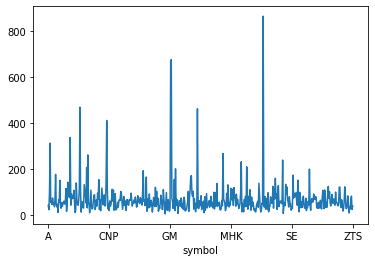

In [495]:
# Plot the distribution of 'close'
ac = companyAveragedprices['close'].plot()

In [496]:
# Check for outliers
companyAveragedprices['volume'].sort_values()

symbol
MTD     1.840526e+05
ESS     3.548340e+05
AZO     3.578816e+05
SNA     3.651510e+05
DNB     3.667950e+05
            ...     
MSFT    4.579784e+07
GE      4.855166e+07
F       4.935228e+07
AAPL    9.422578e+07
BAC     1.423870e+08
Name: volume, Length: 501, dtype: float64

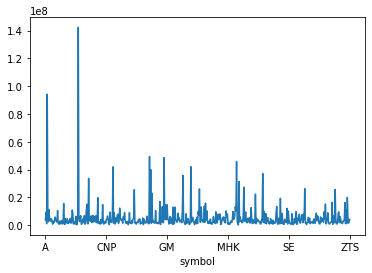

In [497]:
# Plot the distribution of 'volume'
ad = companyAveragedprices['volume'].plot()

While companies like GOOGL and PCLN close prices are much higher than the rest, they will not be treated as outliers or anomalies with the dataset. Likewise, with AAPL and BAC with higher volume than the rest will be not be removed from dataset

In [498]:
# Merge companyAveragedprices dataset with reduced dataset
features_reduced_with_prices = features_reduced.join(companyAveragedprices)

In [499]:
# Remove features open, low and high
features_reduced_with_prices = features_reduced_with_prices.drop(columns=['open', 'low', 'high'])

In [500]:
# Inspect the newly created dataset 'features_reduced_with_prices'
features_reduced_with_prices.head()

,Accounts Payable,Accounts Receivable,Add'l income/expense items,Capital Surplus,Changes in Inventories,Common Stocks,Deferred Asset Charges,Deferred Liability Charges,Depreciation,Effect of Exchange Rate,...,Total Equity,Total Liabilities & Equity,Total Revenue,Treasury Stock,For Year,Earnings Per Share,Estimated Shares Outstanding,Industry,close,volume
Ticker Symbol,,,,,,,,,,,,,,,,,,,,,
AAL,4.453250e+09,-3.075000e+07,-1.385500e+09,1.050325e+10,0.000000e+00,3.625000e+07,619250000.0,6.635000e+08,1.212500e+09,0.0,...,-7.655000e+08,3.770550e+10,3.380950e+10,-9.175000e+07,2013.5,-0.3600,4.707669e+08,0,23.873768,9.354038e+06
AAP,3.097954e+09,-4.789875e+07,-2.735000e+05,5.544462e+08,-2.338910e+08,7.000000e+03,0.0,2.200690e+08,2.378770e+08,-2169500.0,...,1.797615e+09,6.568878e+09,8.069924e+09,-9.193450e+07,2013.5,5.9625,7.323176e+07,1,103.769597,1.022026e+06
AAPL,5.121600e+10,-2.620250e+09,1.192250e+09,0.000000e+00,-2.675000e+08,2.543600e+10,0.0,3.052500e+09,9.116250e+09,0.0,...,1.206750e+11,2.627175e+11,2.007648e+11,0.000000e+00,2014.5,16.0375,4.559555e+09,2,312.927066,9.422578e+07
ABBV,6.899750e+09,-8.600000e+07,-2.297500e+08,5.236250e+09,-2.240000e+08,1.225000e+07,0.0,1.358750e+09,9.172500e+08,-217750000.0,...,2.457250e+09,3.419225e+10,1.999725e+10,-2.532750e+09,2014.0,2.2800,1.610405e+09,3,55.473641,8.470789e+06
ABC,1.959230e+10,-1.410580e+09,-1.695250e+07,3.294914e+09,-1.319396e+09,2.729250e+06,0.0,1.100055e+09,2.538910e+08,0.0,...,1.755608e+09,2.551750e+10,1.225849e+11,-3.094310e+09,2014.5,2.3025,2.226236e+08,3,60.957747,2.460256e+06


In [501]:
# Check for nulls
features_reduced_with_prices.info()

<class 'pandas.core.frame.DataFrame'>
Index: 447 entries, AAL to ZTS
Data columns (total 59 columns):
 #   Column                                          Non-Null Count  Dtype  
---  ------                                          --------------  -----  
 0   Accounts Payable                                447 non-null    float64
 1   Accounts Receivable                             447 non-null    float64
 2   Add'l income/expense items                      447 non-null    float64
 3   Capital Surplus                                 447 non-null    float64
 4   Changes in Inventories                          447 non-null    float64
 5   Common Stocks                                   447 non-null    float64
 6   Deferred Asset Charges                          447 non-null    float64
 7   Deferred Liability Charges                      447 non-null    float64
 8   Depreciation                                    447 non-null    float64
 9   Effect of Exchange Rate                       

In [502]:
# Fill nulls with zeros
features_reduced_with_prices = features_reduced_with_prices.fillna(0)

The new dataset with additional features will now be fitted to Random Forest and SVM models to see if there'a difference in performance

In [616]:
# Standardise dataset
ss = StandardScaler()
Xn2 = ss.fit_transform(features_reduced_with_prices)

In [617]:
# Split dataset to train (70%) and test (30%)
X_train, X_test, y_train, y_test = train_test_split(
    Xn2, target, test_size=0.3, random_state=0
)

In [618]:
# Initialise Initialise random forest classifier and train model
randomForestClassifier = RandomForestClassifier(n_estimators=200, n_jobs=-1, random_state=0)
randomForestClassifier.fit(X_train, y_train)
randomForestClassifier.score(X_train, y_train)

1.0

In [619]:
# Calculate accuracy of model using testing data
randomForestClassifier.score(X_test, y_test)

0.7037037037037037

In [620]:
# Mean accuracy after cross validation (5 splits)
scores = cross_val_score(randomForestClassifier, Xn2, target, cv=5)
print('Fold scores:\t\t\t', scores)
print('Cross-validation accuracy:\t', round(scores.mean(), 2))

Fold scores:			 [0.68888889 0.71111111 0.86516854 0.83146067 0.73033708]
Cross-validation accuracy:	 0.77


In [621]:
# Print metrics precision, recall and f1-score
print(classification_report(y_test, randomForestClassifier.predict(X_test)))

              precision    recall  f1-score   support

           0       0.68      0.38      0.49        50
           1       0.71      0.89      0.79        85

    accuracy                           0.70       135
   macro avg       0.69      0.64      0.64       135
weighted avg       0.70      0.70      0.68       135



In [509]:
# Initialise Initialise SVM classifier and train model
SVMClassifier = SVC(kernel='linear')
SVMClassifier.fit(X_train,y_train)
SVMClassifier.score(X_train, y_train)

0.8365384615384616

In [510]:
# Calculate accuracy of model using testing data
SVMClassifier.score(X_test, y_test)

0.6888888888888889

In [511]:
# Mean accuracy after cross validation (5 splits)
scores = cross_val_score(SVMClassifier, Xn2, target, cv=5)
print('Fold scores:\t\t\t', scores)
print('Cross-validation accuracy:\t', round(scores.mean(), 2))

Fold scores:			 [0.73333333 0.7        0.79775281 0.74157303 0.71910112]
Cross-validation accuracy:	 0.74


In [512]:
# Print metrics precision, recall and f1-score
print(classification_report(y_test, SVMClassifier.predict(X_test)))

              precision    recall  f1-score   support

           0       0.65      0.34      0.45        50
           1       0.70      0.89      0.78        85

    accuracy                           0.69       135
   macro avg       0.68      0.62      0.62       135
weighted avg       0.68      0.69      0.66       135



The results above show that adding new prices has not improved model performance. The next thing to check is if prices-split-adjusted dataset will improve performance

In [513]:
# Load prices-split-adjusted dataset
prices_adj = pd.read_csv('data_files/prices-split-adjusted.csv')

In [514]:
# Examine shape of prices-split-adjusted
prices_adj.shape

(851264, 7)

In [515]:
# Check prices-split-adjusted dataset
prices_adj.head()

,date,symbol,open,close,low,high,volume
0,2016-01-05,WLTW,123.430000,125.839996,122.309998,126.250000,2163600.0
1,2016-01-06,WLTW,125.239998,119.980003,119.940002,125.540001,2386400.0
2,2016-01-07,WLTW,116.379997,114.949997,114.930000,119.739998,2489500.0
3,2016-01-08,WLTW,115.480003,116.620003,113.500000,117.440002,2006300.0
4,2016-01-11,WLTW,117.010002,114.970001,114.089996,117.330002,1408600.0


In [516]:
# Check datatypes and nulls
prices_adj.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 851264 entries, 0 to 851263
Data columns (total 7 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   date    851264 non-null  object 
 1   symbol  851264 non-null  object 
 2   open    851264 non-null  float64
 3   close   851264 non-null  float64
 4   low     851264 non-null  float64
 5   high    851264 non-null  float64
 6   volume  851264 non-null  float64
dtypes: float64(5), object(2)
memory usage: 45.5+ MB


In [517]:
# Convert date column from a string into a datetime object.
prices_adj['date'] = pd.to_datetime(prices_adj['date'])

In [518]:
#Check summary statistics of prices_adj
prices_adj.describe()

,open,close,low,high,volume
count,851264.000000,851264.000000,851264.000000,851264.000000,8.512640e+05
mean,64.993618,65.011913,64.336541,65.639748,5.415113e+06
std,75.203893,75.201216,74.459518,75.906861,1.249468e+07
min,1.660000,1.590000,1.500000,1.810000,0.000000e+00
25%,31.270000,31.292776,30.940001,31.620001,1.221500e+06
50%,48.459999,48.480000,47.970001,48.959999,2.476250e+06
75%,75.120003,75.139999,74.400002,75.849998,5.222500e+06
max,1584.439941,1578.130005,1549.939941,1600.930054,8.596434e+08


In [519]:
# Summarise prices_adj by Company, by taking the mean of each variable
companyAveragedpricesAdj = prices_adj.groupby(['symbol']).mean()
companyAveragedpricesAdj

,open,close,low,high,volume
symbol,,,,,
A,34.065290,34.080221,33.714101,34.414842,3.927589e+06
AAL,23.875108,23.873768,23.466453,24.283933,9.354038e+06
AAP,103.724540,103.769597,102.685749,104.800505,1.022026e+06
AAPL,79.427744,79.402683,78.640034,80.140447,9.422578e+07
ABBV,55.441081,55.473641,54.829325,56.068165,8.470789e+06
...,...,...,...,...,...
YHOO,27.297917,27.291992,26.975602,27.609977,1.996907e+07
YUM,48.200583,48.223388,47.786350,48.632991,5.163684e+06
ZBH,82.825817,82.873859,82.125414,83.556992,1.509946e+06


In [520]:
# Check for outliers
companyAveragedpricesAdj['close'].sort_values()

symbol
FTR        5.782100
HBAN       8.117157
RF         8.282838
ARNC       9.015396
XRX        9.992565
            ...    
GOOG     459.617409
ISRG     461.974904
GOOGL    467.088977
AZO      469.007747
PCLN     863.456878
Name: close, Length: 501, dtype: float64

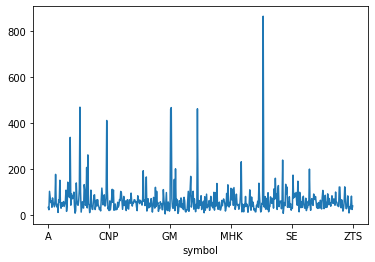

In [521]:
# Plot the distribution of 'close'
ad = companyAveragedpricesAdj['close'].plot()

In [522]:
# Check for outliers
companyAveragedpricesAdj['volume'].sort_values()

symbol
MTD     1.840526e+05
ESS     3.548340e+05
AZO     3.578816e+05
SNA     3.651510e+05
DNB     3.667950e+05
            ...     
MSFT    4.579784e+07
GE      4.855166e+07
F       4.935228e+07
AAPL    9.422578e+07
BAC     1.423870e+08
Name: volume, Length: 501, dtype: float64

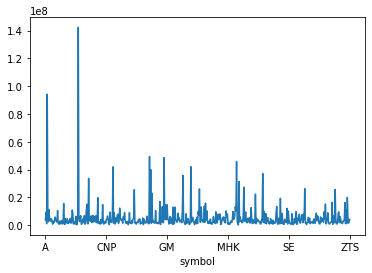

In [523]:
# Plot the distribution of 'volume'
ad = companyAveragedpricesAdj['volume'].plot()

Similarly with prices dataset, companies with highest values for close and volume will not be treated as a data anomaly and will not be removed from the dataset

In [524]:
# Merge companyAveragedpricesAdj dataset with reduced dataset
features_reduced_with_prices_adj = features_reduced.join(companyAveragedpricesAdj)

In [525]:
# Remove features open, low and high
features_reduced_with_prices_adj = features_reduced_with_prices_adj.drop(columns=['open', 'low', 'high'])

In [526]:
# Inspect the newly created dataset 'features_reduced_with_prices'
features_reduced_with_prices_adj.head()

,Accounts Payable,Accounts Receivable,Add'l income/expense items,Capital Surplus,Changes in Inventories,Common Stocks,Deferred Asset Charges,Deferred Liability Charges,Depreciation,Effect of Exchange Rate,...,Total Equity,Total Liabilities & Equity,Total Revenue,Treasury Stock,For Year,Earnings Per Share,Estimated Shares Outstanding,Industry,close,volume
Ticker Symbol,,,,,,,,,,,,,,,,,,,,,
AAL,4.453250e+09,-3.075000e+07,-1.385500e+09,1.050325e+10,0.000000e+00,3.625000e+07,619250000.0,6.635000e+08,1.212500e+09,0.0,...,-7.655000e+08,3.770550e+10,3.380950e+10,-9.175000e+07,2013.5,-0.3600,4.707669e+08,0,23.873768,9.354038e+06
AAP,3.097954e+09,-4.789875e+07,-2.735000e+05,5.544462e+08,-2.338910e+08,7.000000e+03,0.0,2.200690e+08,2.378770e+08,-2169500.0,...,1.797615e+09,6.568878e+09,8.069924e+09,-9.193450e+07,2013.5,5.9625,7.323176e+07,1,103.769597,1.022026e+06
AAPL,5.121600e+10,-2.620250e+09,1.192250e+09,0.000000e+00,-2.675000e+08,2.543600e+10,0.0,3.052500e+09,9.116250e+09,0.0,...,1.206750e+11,2.627175e+11,2.007648e+11,0.000000e+00,2014.5,16.0375,4.559555e+09,2,79.402683,9.422578e+07
ABBV,6.899750e+09,-8.600000e+07,-2.297500e+08,5.236250e+09,-2.240000e+08,1.225000e+07,0.0,1.358750e+09,9.172500e+08,-217750000.0,...,2.457250e+09,3.419225e+10,1.999725e+10,-2.532750e+09,2014.0,2.2800,1.610405e+09,3,55.473641,8.470789e+06
ABC,1.959230e+10,-1.410580e+09,-1.695250e+07,3.294914e+09,-1.319396e+09,2.729250e+06,0.0,1.100055e+09,2.538910e+08,0.0,...,1.755608e+09,2.551750e+10,1.225849e+11,-3.094310e+09,2014.5,2.3025,2.226236e+08,3,60.957747,2.460256e+06


In [527]:
# Check for nulls
features_reduced_with_prices_adj.info()

<class 'pandas.core.frame.DataFrame'>
Index: 447 entries, AAL to ZTS
Data columns (total 59 columns):
 #   Column                                          Non-Null Count  Dtype  
---  ------                                          --------------  -----  
 0   Accounts Payable                                447 non-null    float64
 1   Accounts Receivable                             447 non-null    float64
 2   Add'l income/expense items                      447 non-null    float64
 3   Capital Surplus                                 447 non-null    float64
 4   Changes in Inventories                          447 non-null    float64
 5   Common Stocks                                   447 non-null    float64
 6   Deferred Asset Charges                          447 non-null    float64
 7   Deferred Liability Charges                      447 non-null    float64
 8   Depreciation                                    447 non-null    float64
 9   Effect of Exchange Rate                       

In [528]:
# Fill nulls with zeros
features_reduced_with_prices_adj = features_reduced_with_prices_adj.fillna(0)

In [529]:
# Standardise dataset
ss = StandardScaler()
Xn3 = ss.fit_transform(features_reduced_with_prices_adj)

In [530]:
# Split dataset to train (70%) and test (30%)
X_train, X_test, y_train, y_test = train_test_split(
    Xn3, target, test_size=0.3, random_state=0
)

In [531]:
# Initialise Initialise random forest classifier and train model
randomForestClassifier = RandomForestClassifier(n_estimators=200, n_jobs=-1, random_state=0)
randomForestClassifier.fit(X_train, y_train)
randomForestClassifier.score(X_train, y_train)

1.0

In [532]:
# Calculate accuracy of model using testing data
randomForestClassifier.score(X_test, y_test)

0.7037037037037037

In [533]:
# Mean accuracy after cross validation (5 splits)
scores = cross_val_score(randomForestClassifier, Xn3, target, cv=5)
print('Fold scores:\t\t\t', scores)
print('Cross-validation accuracy:\t', round(scores.mean(), 2))

Fold scores:			 [0.71111111 0.72222222 0.87640449 0.82022472 0.73033708]
Cross-validation accuracy:	 0.77


In [534]:
# Print metrics precision, recall and f1-score
print(classification_report(y_test, randomForestClassifier.predict(X_test)))

              precision    recall  f1-score   support

           0       0.69      0.36      0.47        50
           1       0.71      0.91      0.79        85

    accuracy                           0.70       135
   macro avg       0.70      0.63      0.63       135
weighted avg       0.70      0.70      0.68       135



In [535]:
# Initialise Initialise SVM classifier and train model
SVMClassifier = SVC(kernel='linear')
SVMClassifier.fit(X_train,y_train)
SVMClassifier.score(X_train, y_train)

0.8461538461538461

In [536]:
# Calculate accuracy of model using testing data
SVMClassifier.score(X_test, y_test)

0.6962962962962963

In [537]:
# Mean accuracy after cross validation (5 splits)
scores = cross_val_score(SVMClassifier, Xn3, target, cv=5)
print('Fold scores:\t\t\t', scores)
print('Cross-validation accuracy:\t', round(scores.mean(), 2))

Fold scores:			 [0.73333333 0.71111111 0.79775281 0.70786517 0.69662921]
Cross-validation accuracy:	 0.73


In [538]:
# Print metrics precision, recall and f1-score
print(classification_report(y_test, SVMClassifier.predict(X_test)))

              precision    recall  f1-score   support

           0       0.68      0.34      0.45        50
           1       0.70      0.91      0.79        85

    accuracy                           0.70       135
   macro avg       0.69      0.62      0.62       135
weighted avg       0.69      0.70      0.67       135



Similarly to the prices dataset, adding features from prices-split-adjusted did not improve model performance. For this reason, the additional features will not be added to final version of the models. Both versions of the models with some correlated features removed show similar performance. However, with Random Forest having the highest Precision (0 - True negatives) at 0.77, it will be the final model selected.

### Extract important features

In [548]:
# Extract important features of Random Forest classifier

labels = features_reduced.columns.values
weights = randomForestClassifier.feature_importances_
top_features = sorted(list(zip(labels,weights)), reverse=True, key = lambda x: abs(x[1]))[0:10]
top_labels = [x[0] for x in top_features]
top_weights = [x[1] for x in top_features]
pp.pprint(top_labels)
pp.pprint(top_weights)

[   'Liabilities',
    'Accounts Receivable',
    'Non-Recurring Items',
    'Retained Earnings',
    'Common Stocks',
    'Other Equity',
    'Net Cash Flows-Financing',
    'Other Investing Activities',
    'Industry',
    'Other Assets']
[   0.06294031333457192,
    0.04055367659598279,
    0.03889673241193252,
    0.033400013395368716,
    0.030139628399118993,
    0.02744209123851058,
    0.025889878116595804,
    0.02578921813433785,
    0.025171055142253724,
    0.024446147245993862]


# 3. Hyperparameter tuning (model optimisation)
This section is to find the most optimum parameters to try to improve model performance further. 

For Random Forest, the hyperparameters are:

-  the max_depth
-  min_sample_split
- max_leaf_nodes
-  min_samples_leaf
-  n_estimators
- max_sample (bootstrap sample)
- max_features
 

In [660]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)

{'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}


In [661]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
# Random search of parameters, using 3 fold cross validation, 
from sklearn.model_selection import RandomizedSearchCV# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = randomForestClassifier, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=0, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


RandomizedSearchCV(cv=3,
                   estimator=RandomForestClassifier(n_estimators=200, n_jobs=-1,
                                                    random_state=0),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   random_state=0, verbose=2)

In [659]:
rf_random.best_params_

{'n_estimators': 288,
 'min_samples_split': 10,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': 40,
 'bootstrap': True}

In [667]:
# Rerun model with best parameters

randomForestClassifier = RandomForestClassifier(n_estimators=800, max_depth=50, random_state=0)
randomForestClassifier.fit(X_train, y_train)
randomForestClassifier.score(X_train, y_train)

1.0

In [668]:
randomForestClassifier.score(X_test, y_test)

0.7407407407407407

The result of the hyperparameter tuning has improved model by 1%

In [559]:
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit

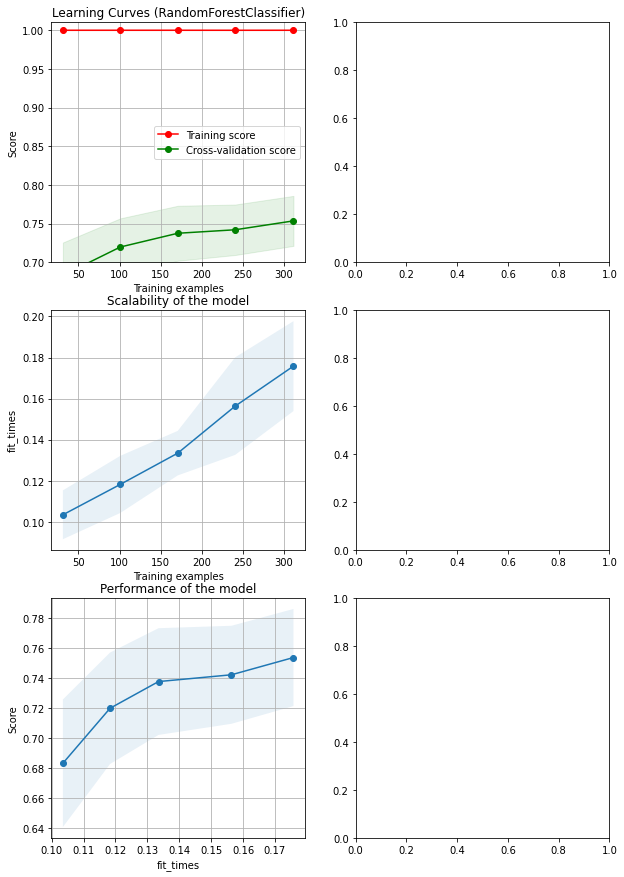

In [627]:
#import numpy as np
#import matplotlib.pyplot as plt
#from sklearn.naive_bayes import GaussianNB
#from sklearn.svm import SVC
#from sklearn.datasets import load_digits
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit


def plot_learning_curve(
    estimator,
    title,
    X,
    y,
    axes=None,
    ylim=None,
    cv=None,
    n_jobs=None,
    train_sizes=np.linspace(0.1, 1.0, 5),
):
    """
    Generate 3 plots: the test and training learning curve, the training
    samples vs fit times curve, the fit times vs score curve.

    Parameters
    ----------
    estimator : estimator instance
        An estimator instance implementing `fit` and `predict` methods which
        will be cloned for each validation.

    title : str
        Title for the chart.

    X : array-like of shape (n_samples, n_features)
        Training vector, where ``n_samples`` is the number of samples and
        ``n_features`` is the number of features.

    y : array-like of shape (n_samples) or (n_samples, n_features)
        Target relative to ``X`` for classification or regression;
        None for unsupervised learning.

    axes : array-like of shape (3,), default=None
        Axes to use for plotting the curves.

    ylim : tuple of shape (2,), default=None
        Defines minimum and maximum y-values plotted, e.g. (ymin, ymax).

    cv : int, cross-validation generator or an iterable, default=None
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:

          - None, to use the default 5-fold cross-validation,
          - integer, to specify the number of folds.
          - :term:`CV splitter`,
          - An iterable yielding (train, test) splits as arrays of indices.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : int or None, default=None
        Number of jobs to run in parallel.
        ``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.
        ``-1`` means using all processors. See :term:`Glossary <n_jobs>`
        for more details.

    train_sizes : array-like of shape (n_ticks,)
        Relative or absolute numbers of training examples that will be used to
        generate the learning curve. If the ``dtype`` is float, it is regarded
        as a fraction of the maximum size of the training set (that is
        determined by the selected validation method), i.e. it has to be within
        (0, 1]. Otherwise it is interpreted as absolute sizes of the training
        sets. Note that for classification the number of samples usually have
        to be big enough to contain at least one sample from each class.
        (default: np.linspace(0.1, 1.0, 5))
    """
    if axes is None:
        _, axes = plt.subplots(1, 3, figsize=(20, 5))

    axes[0].set_title(title)
    if ylim is not None:
        axes[0].set_ylim(*ylim)
    axes[0].set_xlabel("Training examples")
    axes[0].set_ylabel("Score")

    train_sizes, train_scores, test_scores, fit_times, _ = learning_curve(
        estimator,
        X,
        y,
        cv=cv,
        n_jobs=n_jobs,
        train_sizes=train_sizes,
        return_times=True,
    )
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    # Plot learning curve
    axes[0].grid()
    axes[0].fill_between(
        train_sizes,
        train_scores_mean - train_scores_std,
        train_scores_mean + train_scores_std,
        alpha=0.1,
        color="r",
    )
    axes[0].fill_between(
        train_sizes,
        test_scores_mean - test_scores_std,
        test_scores_mean + test_scores_std,
        alpha=0.1,
        color="g",
    )
    axes[0].plot(
        train_sizes, train_scores_mean, "o-", color="r", label="Training score"
    )
    axes[0].plot(
        train_sizes, test_scores_mean, "o-", color="g", label="Cross-validation score"
    )
    axes[0].legend(loc="best")

    # Plot n_samples vs fit_times
    axes[1].grid()
    axes[1].plot(train_sizes, fit_times_mean, "o-")
    axes[1].fill_between(
        train_sizes,
        fit_times_mean - fit_times_std,
        fit_times_mean + fit_times_std,
        alpha=0.1,
    )
    axes[1].set_xlabel("Training examples")
    axes[1].set_ylabel("fit_times")
    axes[1].set_title("Scalability of the model")

    # Plot fit_time vs score
    axes[2].grid()
    axes[2].plot(fit_times_mean, test_scores_mean, "o-")
    axes[2].fill_between(
        fit_times_mean,
        test_scores_mean - test_scores_std,
        test_scores_mean + test_scores_std,
        alpha=0.1,
    )
    axes[2].set_xlabel("fit_times")
    axes[2].set_ylabel("Score")
    axes[2].set_title("Performance of the model")

    return plt


fig, axes = plt.subplots(3, 2, figsize=(10, 15))

#X, y = load_digits(return_X_y=True)

title = "Learning Curves (RandomForestClassifier)"
# Cross validation with 100 iterations to get smoother mean test and train
# score curves, each time with 30% data randomly selected as a validation set.
cv = ShuffleSplit(n_splits=100, test_size=0.3, random_state=0)

estimator = RandomForestClassifier()
plot_learning_curve(
    estimator, title, X_train, y_train, axes=axes[:, 0], ylim=(0.7, 1.01), cv=cv, n_jobs=4
)

title = r"Learning Curves (SVM, RBF kernel, $\gamma=0.001$)"
# SVC is more expensive so we do a lower number of CV iterations:
cv = ShuffleSplit(n_splits=10, test_size=0.3, random_state=0)
estimator = SVMClassifier(1)
plot_learning_curve(
    estimator, title, X_train, y_train, axes=axes[:, 1], ylim=(0.7, 1.01), cv=cv, n_jobs=4
)

plt.show()

In [564]:
from mlxtend.evaluate import bias_variance_decomp

In [566]:
def get_bias_var(tree, X_train, y_train, X_test, y_test, loss_type):
    avg_expected_loss, avg_bias, avg_var = bias_variance_decomp(tree, X_train, y_train, X_test, y_test, loss=loss_type, random_seed=1)

    print('Average expected loss: %.3f' % avg_expected_loss)
    print('Average bias: %.3f' % avg_bias)
    print('Average variance: %.3f' % avg_var)
    return

In [590]:
X_train, X_test, y_train, y_test = train_test_split(Xn1, target, test_size=0.3, random_state=1, shuffle=True)
tree = RandomForestClassifier(random_state=0)
error_dt, bias_dt, var_dt = bias_variance_decomp(tree, X_train, y_train, X_test, y_test,'mse', random_seed=1)

tree_pruned = RandomForestClassifier(random_state=1, max_depth=2)
error_dt_pruned, bias_dt_pruned, var_dt_pruned = bias_variance_decomp(tree_pruned, X_train, y_train, X_test, y_test,'mse', random_seed=123)

print("variance Reduction:", str(np.round((var_dt_pruned/var_dt-1)*100,2)) + '%')
print("At the expense of introducing bias:", str(np.round((bias_dt_pruned/bias_dt-1)*100, 2)) + '%')

variance Reduction: -22.19%
At the expense of introducing bias: 11.06%


In [669]:
from sklearn.metrics import zero_one_loss

avg_expected_loss, avg_bias, avg_var = bias_variance_decomp(
        randomForestClassifier, X_train, y_train, X_test, y_test, 
        loss='0-1_loss',
        random_seed=1)

print('Average expected loss: %.3f' % avg_expected_loss)
print('Average bias: %.3f' % avg_bias)
print('Average variance: %.3f' % avg_var)
print('Sklearn 0-1 loss: %.3f' % zero_one_loss(y_test,y_test))

Average expected loss: 0.286
Average bias: 0.296
Average variance: 0.074
Sklearn 0-1 loss: 0.000


In [574]:
# Create a model with just the important features

important_features = features_reduced[['Liabilities','Accounts Receivable','Non-Recurring Items',
    'Retained Earnings',
    'Common Stocks',
    'Other Equity',
    'Net Cash Flows-Financing',
    'Other Investing Activities',
    'Industry',
    'Other Assets']]
important_features

,Liabilities,Accounts Receivable,Non-Recurring Items,Retained Earnings,Common Stocks,Other Equity,Net Cash Flows-Financing,Other Investing Activities,Industry,Other Assets
Ticker Symbol,,,,,,,,,,
AAL,-3.552500e+08,-3.075000e+07,6.990000e+08,-7.637500e+09,3.625000e+07,-3.575750e+09,6.770000e+08,3.017500e+08,0,2.157250e+09
AAP,2.419820e+08,-4.789875e+07,0.000000e+00,1.347608e+09,7.000000e+03,-1.251150e+07,1.472708e+08,-5.616390e+08,1,4.996300e+07
AAPL,8.762250e+09,-2.620250e+09,0.000000e+00,9.501400e+10,2.543600e+10,2.250000e+08,-2.303175e+10,-1.844750e+09,2,5.772250e+09
ABBV,3.825000e+07,-8.600000e+07,2.820000e+08,1.087500e+09,1.225000e+07,-1.346000e+09,2.370000e+08,-3.537000e+09,3,1.057750e+09
ABC,3.589478e+09,-1.410580e+09,0.000000e+00,1.636818e+09,2.729250e+06,-8.454250e+07,-3.277602e+08,-1.260209e+09,3,2.962910e+08
...,...,...,...,...,...,...,...,...,...,...
YHOO,7.679375e+07,1.279100e+07,1.280004e+09,5.891235e+09,1.026500e+06,9.871324e+09,-2.030766e+09,2.034925e+09,2,5.471555e+08
YUM,2.800000e+07,-2.625000e+07,2.455000e+08,1.818750e+09,0.000000e+00,-1.242500e+08,-1.393250e+09,1.612500e+08,1,5.587500e+08
ZBH,-3.525000e+06,-5.407500e+07,4.086500e+08,7.877100e+09,2.725000e+06,1.050250e+08,1.418400e+09,-1.983725e+09,3,7.937500e+08


In [575]:
# Standardise dataset
ss = StandardScaler()
Xn4 = ss.fit_transform(important_features)

In [577]:
# Split dataset to train (70%) and test (30%)
X_train, X_test, y_train, y_test = train_test_split(
    Xn4, target, test_size=0.3, random_state=0
)

In [579]:
randomForestClassifier = RandomForestClassifier(n_estimators=800, max_depth=50, random_state=0)
randomForestClassifier.fit(X_train, y_train)
randomForestClassifier.score(X_train, y_train)

1.0

In [580]:
# Calculate accuracy of model using testing data
randomForestClassifier.score(X_test, y_test)

0.7333333333333333

In [581]:
# Mean accuracy after cross validation (5 splits)
scores = cross_val_score(randomForestClassifier, X_test, y_test, cv=5)
print('Fold scores:\t\t\t', scores)
print('Cross-validation accuracy:\t', round(scores.mean(), 2))

Fold scores:			 [0.66666667 0.59259259 0.77777778 0.74074074 0.74074074]
Cross-validation accuracy:	 0.7


In [582]:
# Print metrics precision, recall and f1-score
print(classification_report(y_test, randomForestClassifier.predict(X_test)))

              precision    recall  f1-score   support

           0       0.72      0.46      0.56        50
           1       0.74      0.89      0.81        85

    accuracy                           0.73       135
   macro avg       0.73      0.68      0.68       135
weighted avg       0.73      0.73      0.72       135



By using the 10 most important features only have provided almost the same performance as the original with 70+ features.

In [302]:
# Print out the predictions
predictions = pd.DataFrame(y_test)

In [385]:
# Add company names to predictions
predictions_names = pd.merge(predictions, securities, left_index=True, right_index=True)
predictions_names

,revGrowthAboveSeven,Security,SEC filings,GICS Sector,GICS Sub Industry,Address of Headquarters,Date first added,CIK,Avg Rev Growth
Ticker Symbol,,,,,,,,,
SNI,1,Scripps Networks Interactive Inc.,reports,Consumer Discretionary,Broadcasting & Cable TV,"Cincinnati, Ohio",1/7/08,1430602,7.704691
VRTX,0,Vertex Pharmaceuticals Inc,reports,Health Care,Biotechnology,"Cambridge, Massachusetts",23/9/13,875320,-8.099090
OKE,0,ONEOK,reports,Energy,Oil & Gas Exploration & Production,"Tulsa, Oklahoma",15/3/10,1039684,-5.942867
VIAB,0,Viacom Inc.,reports,Consumer Discretionary,Broadcasting & Cable TV,"New York, New York",NaN,1339947,-2.366971
EQT,0,EQT Corporation,reports,Energy,Oil & Gas Exploration & Production,"Pittsburgh, Pennsylvania",19/12/08,33213,-0.024715
...,...,...,...,...,...,...,...,...,...
ED,0,Consolidated Edison,reports,Utilities,Electric Utilities,"New York, New York",NaN,1047862,-0.564594
WAT,1,Waters Corporation,reports,Health Care,Health Care Distributors,"Milford, Massachusetts",NaN,1000697,2.694275
WM,0,Waste Management Inc.,reports,Industrials,Environmental Services,"Houston, Texas",NaN,823768,-0.668669


In [388]:
# Filter by revGrowthAboveSeven = 1
growth_companies = predictions_names.loc[predictions_names['revGrowthAboveSeven'] == 1]
growth_companies.shape

(85, 9)

In [390]:
# Filter by revGrowthAboveSeven = 1 and sort by Avg Rev Growth. Show top 50
top_30 = predictions_names.loc[predictions_names['revGrowthAboveSeven'] == 1].sort_values(by='Avg Rev Growth', ascending=False)[0:30]
top_30

,revGrowthAboveSeven,Security,SEC filings,GICS Sector,GICS Sub Industry,Address of Headquarters,Date first added,CIK,Avg Rev Growth
Ticker Symbol,,,,,,,,,
CHTR,1,Charter Communications,reports,Consumer Discretionary,Cable & Satellite,"Stamford, Connecticut",8/9/16,1091667,63.911711
FB,1,Facebook,reports,Information Technology,Internet Software & Services,"Menlo Park, California",23/12/13,1326801,62.773120
PG,1,Procter & Gamble,reports,Consumer Staples,Personal Products,"Cincinnati, Ohio",NaN,80424,32.731780
MAA,1,Mid-America Apartments,reports,Real Estate,Residential REITs,"Memphis, Tennessee",2/12/16,912595,29.780694
CRM,1,Salesforce.com,reports,Information Technology,Internet Software & Services,"San Francisco, California",15/9/08,1108524,29.645818
UA,1,Under Armour,reports,Consumer Discretionary,"Apparel, Accessories & Luxury Goods","Baltimore, Maryland",1/5/14,1336917,28.998415
KORS,1,Michael Kors Holdings,reports,Consumer Discretionary,"Apparel, Accessories & Luxury Goods","New York, New York",13/11/13,1530721,28.994945
HCN,1,Welltower Inc.,reports,Real Estate,REITs,"Toledo, Ohio",30/1/09,766704,28.450310
O,1,Realty Income Corporation,reports,Real Estate,Retail REITs,"San Diego, California",7/4/15,726728,27.792258


Overall, there are 85 countries predicted to have Avg Rev Growth above seven and above are the top 30 best performers